In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Bil468_Gürcan/Project


Mounted at /content/drive
/content/drive/MyDrive/Bil468_Gürcan/Project


In [2]:
def load_images_from_folder(folder, max_images_per_class=None, flatten=True):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            count_images_for_class = 0
            print("label_folder_path: ", label_folder_path)
            for image_file in os.listdir(label_folder_path):
                if max_images_per_class is not None and count_images_for_class >= max_images_per_class:
                    print(f"Reached maximum number of images for class {label_folder}. Skipping the rest.")
                    break
                count_images_for_class += 1
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                if flatten:
                    images.append(img.flatten())
                else:
                    images.append(img)
                labels.append(label_folder)
    return np.array(images), np.array(labels)

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For 2 folder splittet data => merges them
def prepare_X_y(dataset_name = 'fer2013', max_images_per_class=None):
    if dataset_name == 'fer2013':
        train_folder = './Data/fer2013/train'
        test_folder = './Data/fer2013/validation'
    else:
        train_folder = './Data/Expw-F_sample500/train'
        test_folder = './Data/Expw-F_sample500/validation'
    images_train, labels_train = load_images_from_folder(train_folder, max_images_per_class, flatten=False)
    images_test, labels_test = load_images_from_folder(test_folder, max_images_per_class, flatten=False)
    X = np.concatenate((images_train, images_test), axis=0)
    y = np.concatenate((labels_train, labels_test), axis=0)
    return X, y

In [4]:
X, y = prepare_X_y(dataset_name='fer2013', max_images_per_class=None)

label_folder_path:  ./Data/fer2013/train/happy
label_folder_path:  ./Data/fer2013/train/sad
label_folder_path:  ./Data/fer2013/train/fear
label_folder_path:  ./Data/fer2013/train/surprise
label_folder_path:  ./Data/fer2013/train/neutral
label_folder_path:  ./Data/fer2013/train/angry
label_folder_path:  ./Data/fer2013/train/disgust
label_folder_path:  ./Data/fer2013/validation/angry
label_folder_path:  ./Data/fer2013/validation/disgust
label_folder_path:  ./Data/fer2013/validation/neutral
label_folder_path:  ./Data/fer2013/validation/surprise
label_folder_path:  ./Data/fer2013/validation/happy
label_folder_path:  ./Data/fer2013/validation/sad
label_folder_path:  ./Data/fer2013/validation/fear


In [5]:
from collections import Counter
class_counts = Counter(y)
print(class_counts)

Counter({'happy': 8989, 'neutral': 6198, 'sad': 6077, 'angry': 4953, 'fear': 4721, 'surprise': 4002, 'disgust': 547})


In [6]:
# one hot encode labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(y)

label_dict = {k: v for k, v in enumerate(lb.classes_)}


In [7]:
print(label_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [8]:
from collections import Counter
X_reshaped = X.reshape((X.shape[0], 48, 48,1))


# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=False, stratify=labels)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=labels)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.1, shuffle=True, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), shuffle=True, stratify=y_train)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
class_counts_train = Counter(np.argmax(y_train , axis = 1 ))
class_counts_val = Counter(np.argmax(y_val , axis = 1 ))
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print(" train: ", class_counts_train,"\n val: ", class_counts_val, "\n test: ", class_counts_test)

(28389, 48, 48, 1)
(3549, 48, 48, 1)
(3549, 48, 48, 1)
 train:  Counter({3: 7191, 4: 4958, 5: 4861, 0: 3963, 2: 3777, 6: 3202, 1: 437}) 
 val:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55}) 
 test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


In [9]:
X_train_norm = X_train / 255.
X_val_norm = X_val / 255.
X_test_norm = X_test / 255.

In [25]:
X_train_tensor = tf.convert_to_tensor(X_train_norm, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val_norm, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_norm, dtype=tf.float32)

In [27]:
X_train_rgb = tf.image.grayscale_to_rgb(X_train_tensor)
X_val_rgb = tf.image.grayscale_to_rgb(X_val_tensor)
X_test_rgb = tf.image.grayscale_to_rgb(X_test_tensor)

In [10]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True)

In [28]:
datagen.fit(X_train_rgb)
valgen.fit(X_val_rgb)

In [29]:
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=64)
val_generator = datagen.flow(X_val_rgb, y_val, batch_size=64)

In [35]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# VGG19 Model

In [36]:
from keras.applications import VGG19

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

def get_model(build,classes):
    model=build.layers[-2].output
    model=GlobalAveragePooling2D()(model)
    model=Dense(classes,activation='softmax',name='output_layer')(model)

    return model

head = get_model(vgg, 7)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [37]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11,verbose = 1, restore_best_weights = True,)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 7,min_lr = 1e-7,verbose = 1,)
callbacks = [early_stopping,lr_scheduler]

In [38]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
train_datagen.fit(X_train)


batch_size = 256
epochs = 15

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])

In [39]:
history = model.fit(train_datagen.flow(X_train_rgb,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_val_rgb, y_val),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/15
110/110 [==============================] - 51s 372ms/step - loss: 1.5849 - accuracy: 0.3789 - val_loss: 1.3482 - val_accuracy: 0.4804 - lr: 1.0000e-04
Epoch 2/15
110/110 [==============================] - 47s 423ms/step - loss: 1.2876 - accuracy: 0.5112 - val_loss: 1.2492 - val_accuracy: 0.5120 - lr: 1.0000e-04
Epoch 3/15
110/110 [==============================] - 47s 424ms/step - loss: 1.1873 - accuracy: 0.5500 - val_loss: 1.1560 - val_accuracy: 0.5568 - lr: 1.0000e-04
Epoch 4/15
110/110 [==============================] - 46s 412ms/step - loss: 1.1157 - accuracy: 0.5763 - val_loss: 1.0957 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 5/15
110/110 [==============================] - 46s 416ms/step - loss: 1.0775 - accuracy: 0.5904 - val_loss: 1.0402 - val_accuracy: 0.6137 - lr: 1.0000e-04
Epoch 6/15
110/110 [==============================] - 48s 425ms/step - loss: 1.0311 - accuracy: 0.6109 - val_loss: 1.0119 - val_accuracy: 0.6233 - lr: 1.0000e-04
Epoch 7/15
110/110 [========

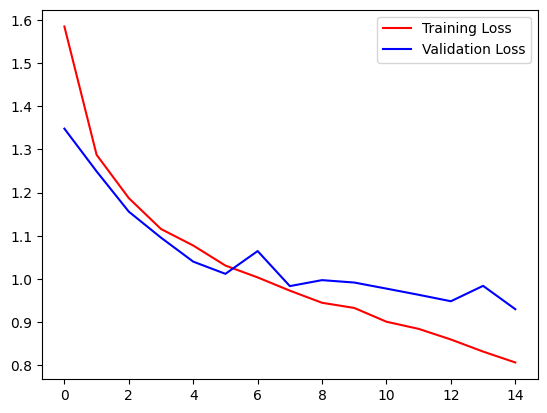

In [40]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

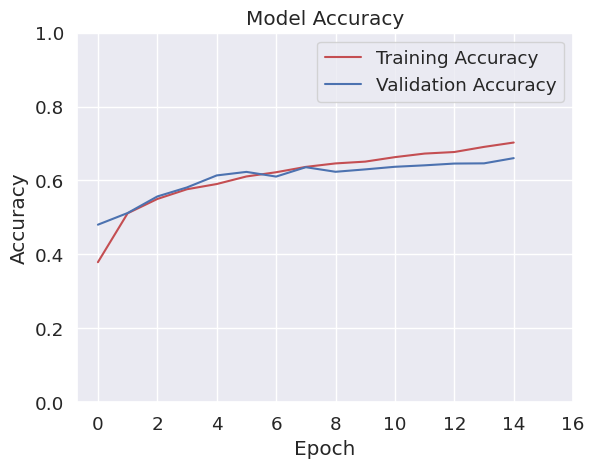

In [53]:
epochs = 15
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [44]:
preds = model.predict(X_test_rgb)
y_pred = np.argmax(preds , axis = 1 )

111/111 [==============================] - 1s 7ms/step


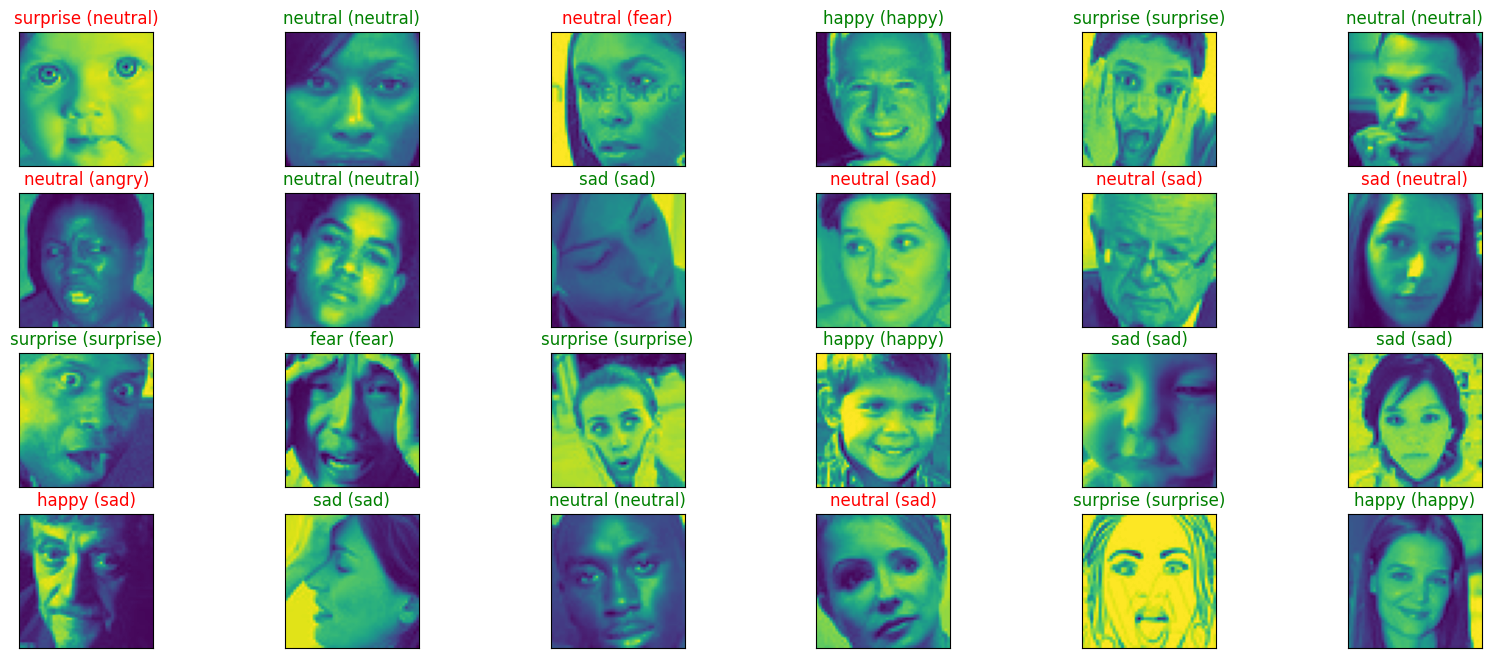

In [45]:
# label_dict = {k: v for k, v in enumerate(lb.classes_)}

# {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [46]:
from collections import Counter
class_counts_predict = Counter(y_pred)
class_counts_test = Counter(np.argmax(y_test , axis = 1 ))
print("predict: ", class_counts_predict, " test: ", class_counts_test)

predict:  Counter({3: 974, 4: 832, 5: 576, 6: 451, 0: 355, 2: 319, 1: 42})  test:  Counter({3: 899, 4: 620, 5: 608, 0: 495, 2: 472, 6: 400, 1: 55})


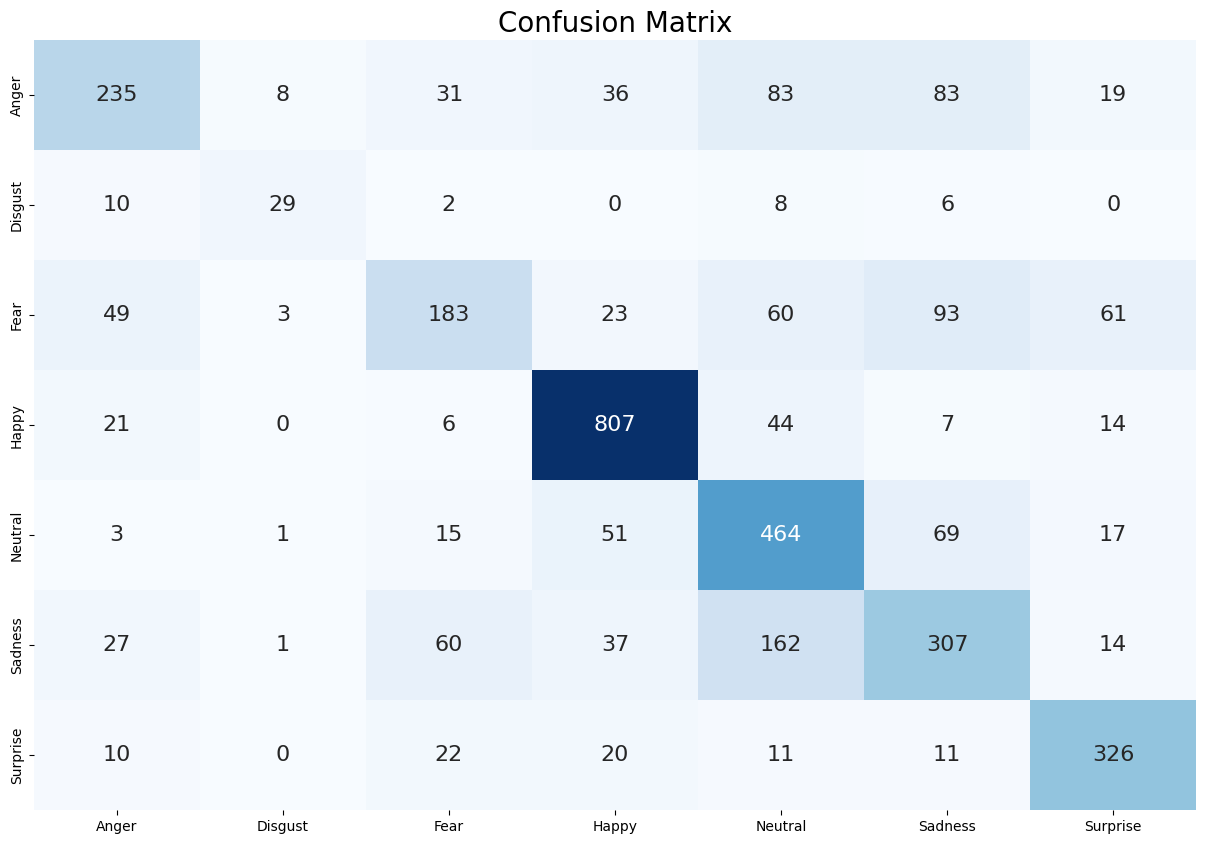

In [47]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()


In [49]:
loss_train = model.evaluate(X_train_rgb,y_train)
loss_val = model.evaluate(X_val_rgb,y_val)
loss_test = model.evaluate(X_test_rgb,y_test)
print("Train Acc: " + str(loss_train[1]), "Vall Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 8ms/step - loss: 0.9311 - accuracy: 0.6624
Train Acc: 0.7409912347793579 Vall Acc: 0.6604677438735962 Test Acc: 0.6624401211738586


# Save the VGG19 Model

In [50]:
model.save('vgg19_cnn.h5')

# Load the VGG19 Model

In [51]:
from keras.models import load_model

loaded_model = load_model('vgg19_cnn.h5')

loss_train = loaded_model.evaluate(X_train_rgb, y_train)
loss_val = loaded_model.evaluate(X_val_rgb, y_val)
loss_test = loaded_model.evaluate(X_test_rgb, y_test)

print("Train Acc: " + str(loss_train[1]), "Val Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))

111/111 [==============================] - 1s 7ms/step - loss: 0.9311 - accuracy: 0.6624
Train Acc: 0.7409912347793579 Val Acc: 0.6604677438735962 Test Acc: 0.6624401211738586


Processing ./Data/fer2013/train/happy/27599.jpg...
1/1 [==============================] - 0s 36ms/step


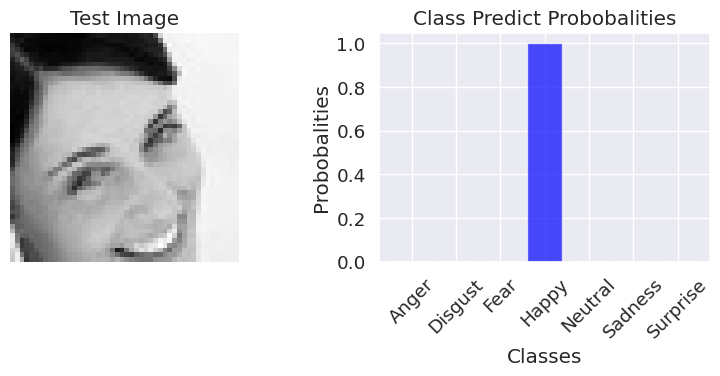

Processing ./Data/fer2013/train/happy/1421.jpg...
1/1 [==============================] - 0s 34ms/step


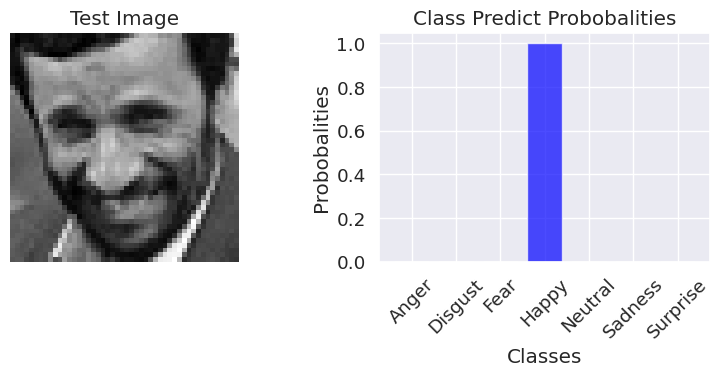

Processing ./Data/fer2013/train/happy/18027.jpg...
1/1 [==============================] - 0s 30ms/step


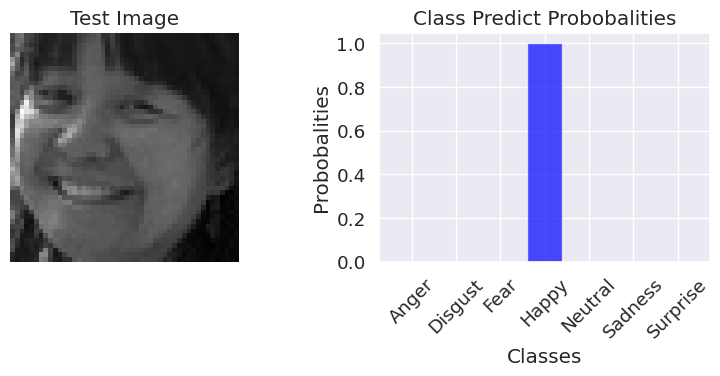

Processing ./Data/fer2013/train/happy/1151.jpg...
1/1 [==============================] - 0s 33ms/step


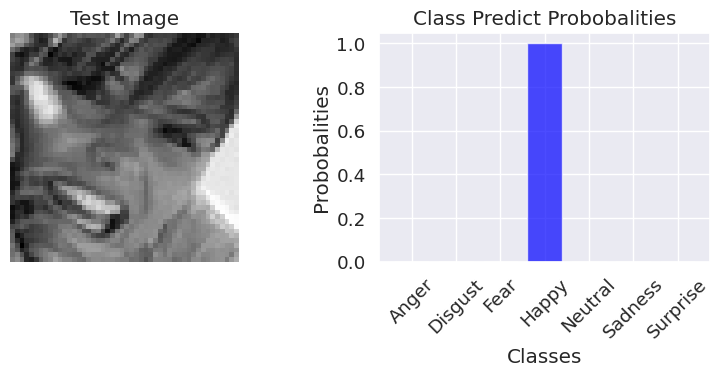

Processing ./Data/fer2013/train/sad/19504.jpg...
1/1 [==============================] - 0s 23ms/step


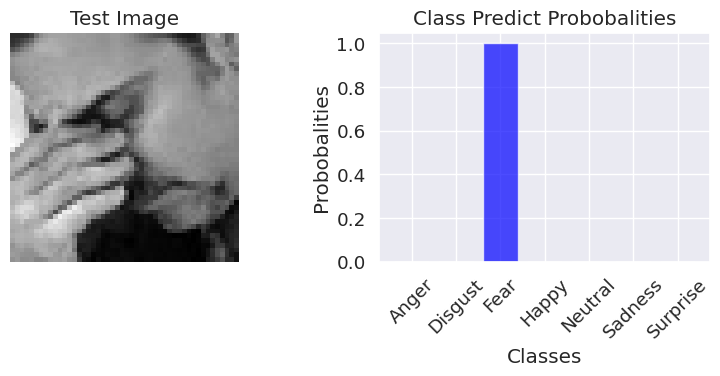

Processing ./Data/fer2013/train/sad/10321.jpg...
1/1 [==============================] - 0s 20ms/step


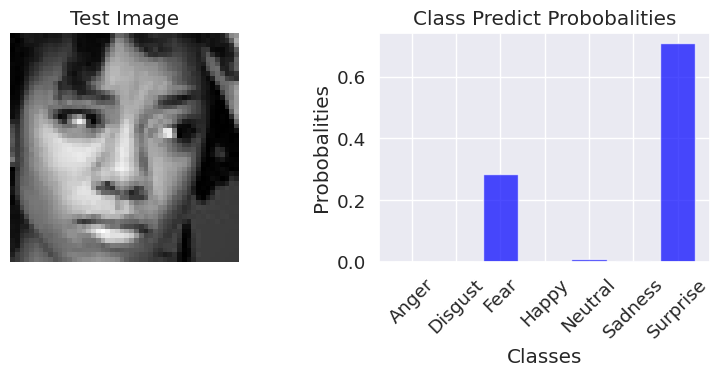

Processing ./Data/fer2013/train/sad/13600.jpg...
1/1 [==============================] - 0s 19ms/step


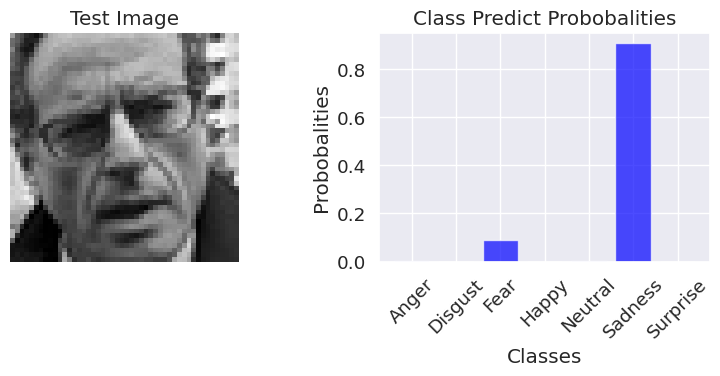

Processing ./Data/fer2013/train/sad/13614.jpg...
1/1 [==============================] - 0s 18ms/step


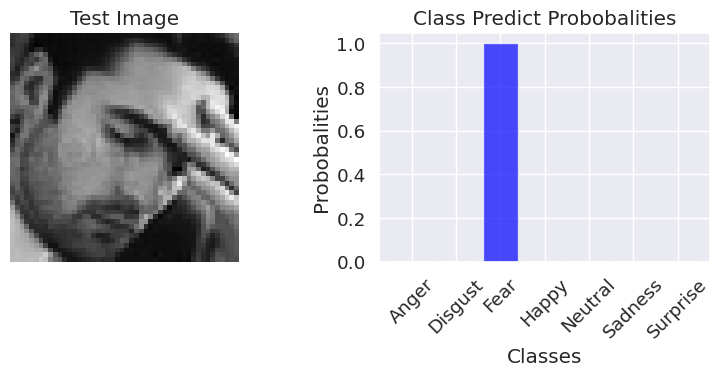

Processing ./Data/fer2013/train/fear/28682.jpg...
1/1 [==============================] - 0s 19ms/step


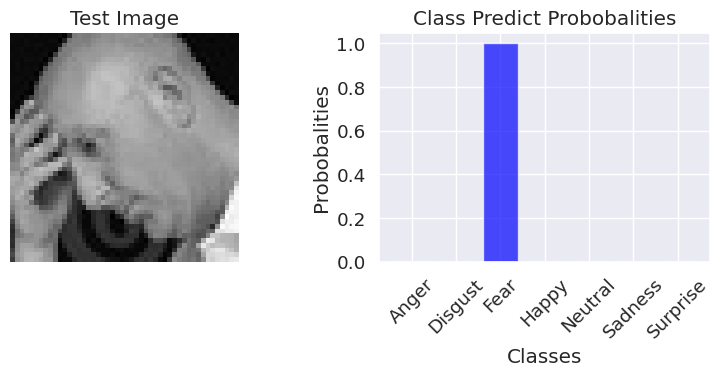

Processing ./Data/fer2013/train/fear/14621.jpg...
1/1 [==============================] - 0s 19ms/step


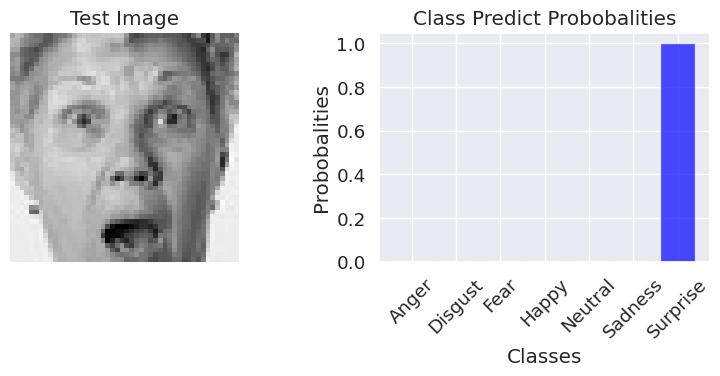

Processing ./Data/fer2013/train/fear/19305.jpg...
1/1 [==============================] - 0s 27ms/step


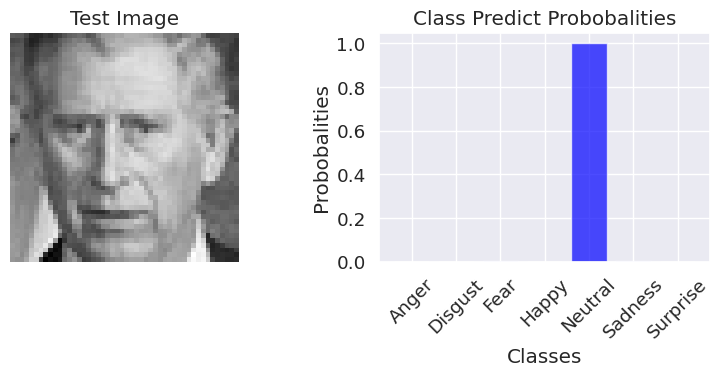

Processing ./Data/fer2013/train/fear/13166.jpg...
1/1 [==============================] - 0s 27ms/step


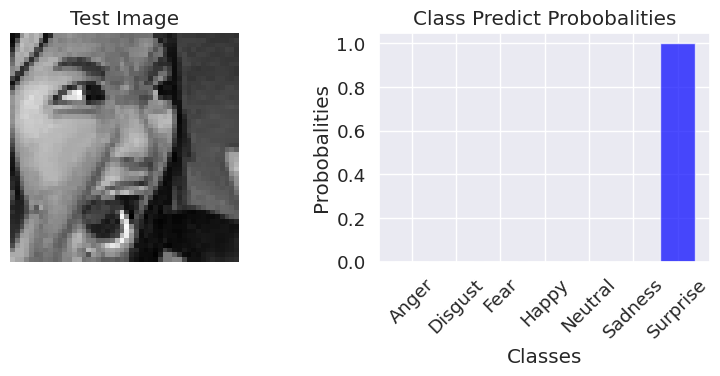

Processing ./Data/fer2013/train/surprise/21895.jpg...
1/1 [==============================] - 0s 28ms/step


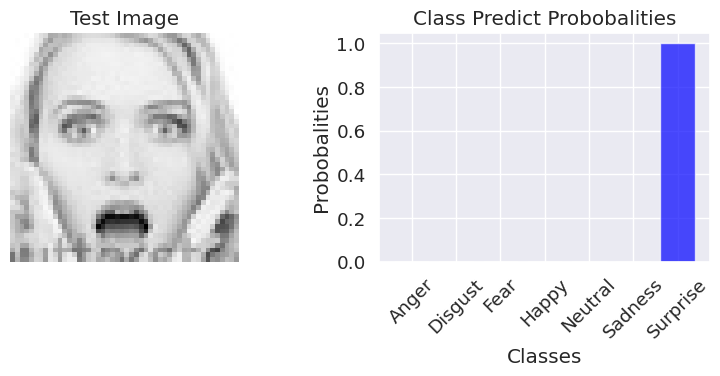

Processing ./Data/fer2013/train/surprise/26136.jpg...
1/1 [==============================] - 0s 31ms/step


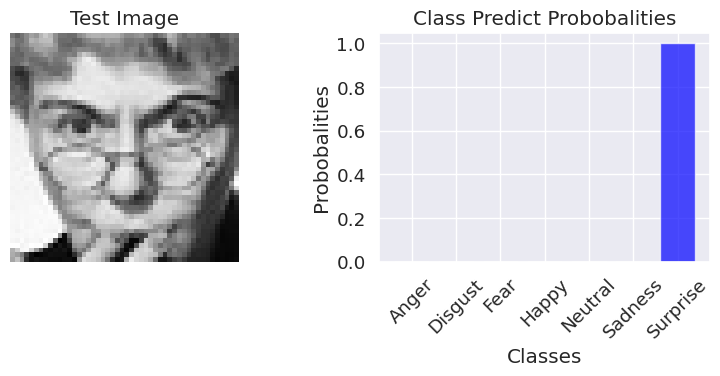

Processing ./Data/fer2013/train/surprise/21856.jpg...
1/1 [==============================] - 0s 20ms/step


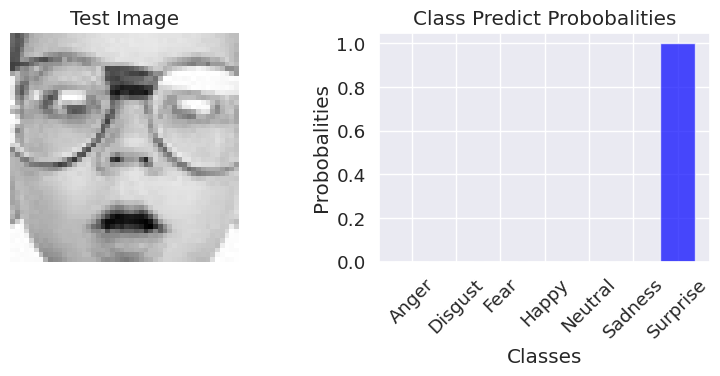

Processing ./Data/fer2013/train/surprise/22393.jpg...
1/1 [==============================] - 0s 20ms/step


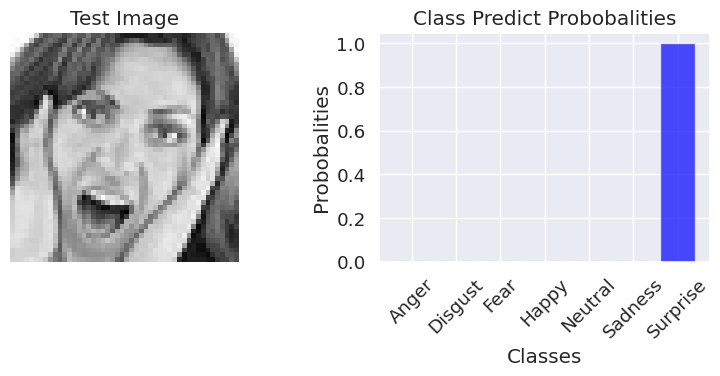

Processing ./Data/fer2013/train/neutral/174.jpg...
1/1 [==============================] - 0s 19ms/step


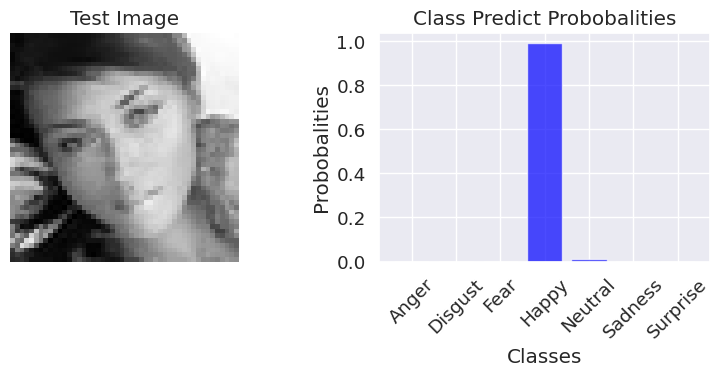

Processing ./Data/fer2013/train/neutral/11983.jpg...
1/1 [==============================] - 0s 20ms/step


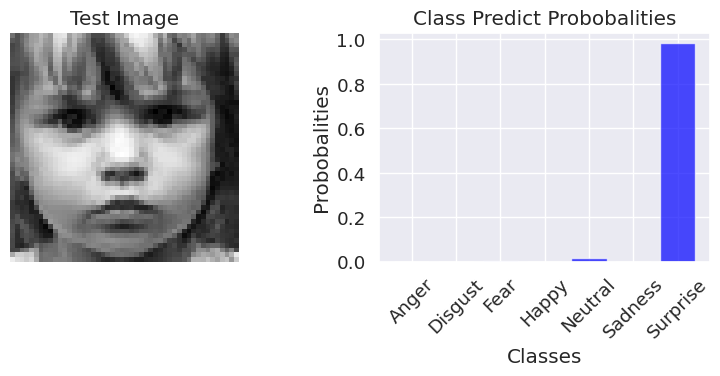

Processing ./Data/fer2013/train/neutral/19307.jpg...
1/1 [==============================] - 0s 21ms/step


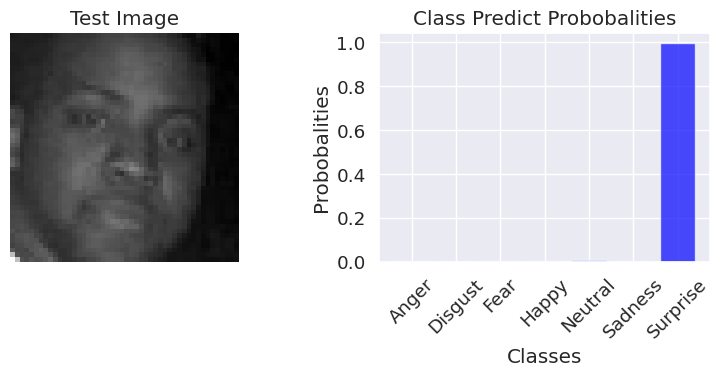

Processing ./Data/fer2013/train/neutral/19061.jpg...
1/1 [==============================] - 0s 25ms/step


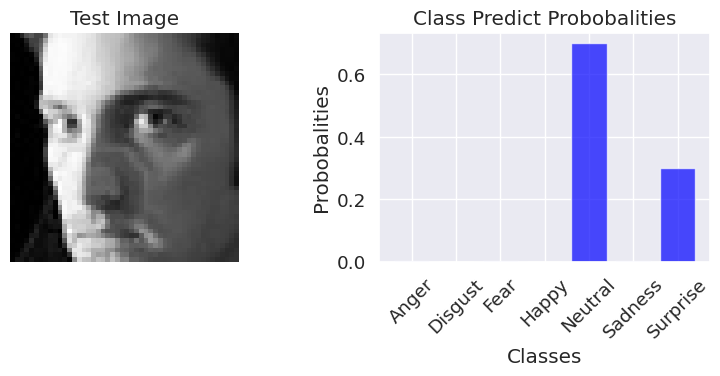

Processing ./Data/fer2013/train/angry/2672.jpg...
1/1 [==============================] - 0s 20ms/step


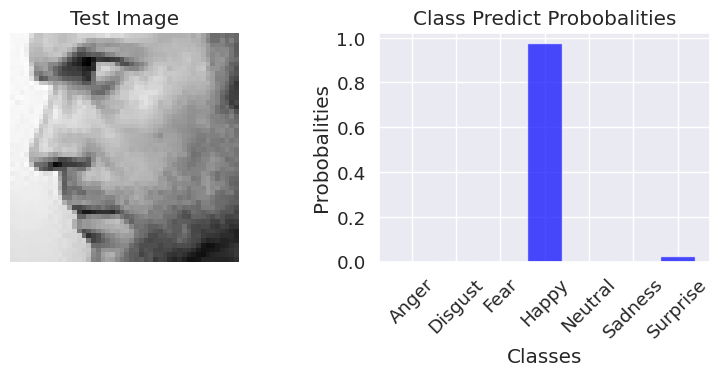

Processing ./Data/fer2013/train/angry/30783.jpg...
1/1 [==============================] - 0s 20ms/step


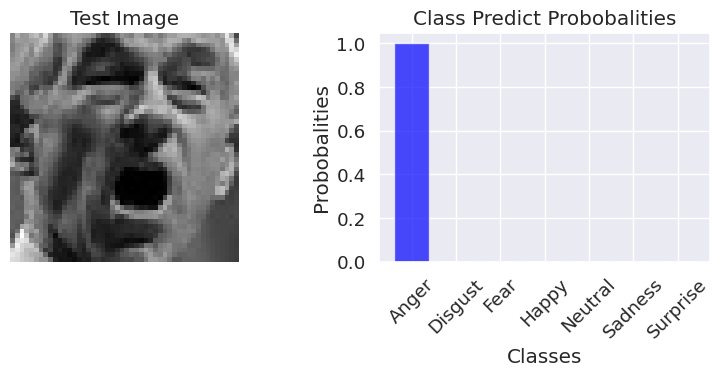

Processing ./Data/fer2013/train/angry/2100.jpg...
1/1 [==============================] - 0s 19ms/step


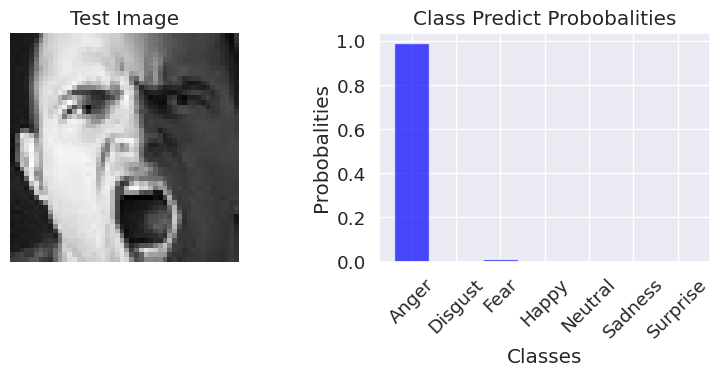

Processing ./Data/fer2013/train/angry/19463.jpg...
1/1 [==============================] - 0s 19ms/step


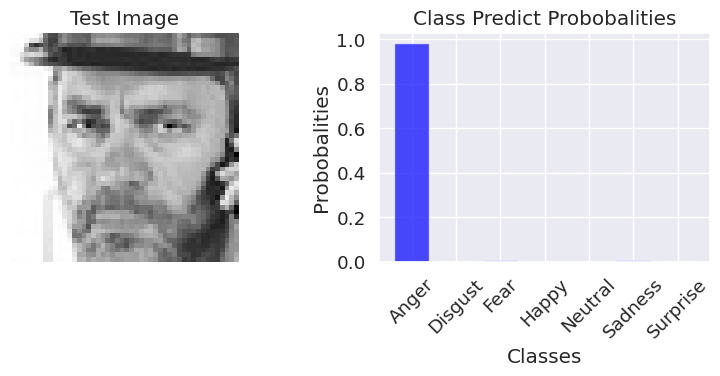

Processing ./Data/fer2013/train/disgust/6548.jpg...
1/1 [==============================] - 0s 19ms/step


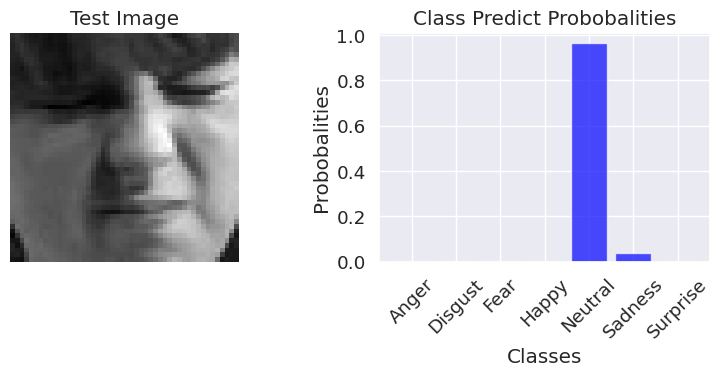

Processing ./Data/fer2013/train/disgust/3626.jpg...
1/1 [==============================] - 0s 21ms/step


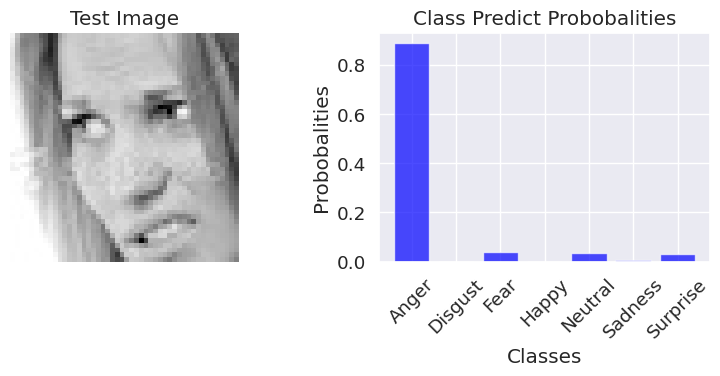

Processing ./Data/fer2013/train/disgust/16591.jpg...
1/1 [==============================] - 0s 19ms/step


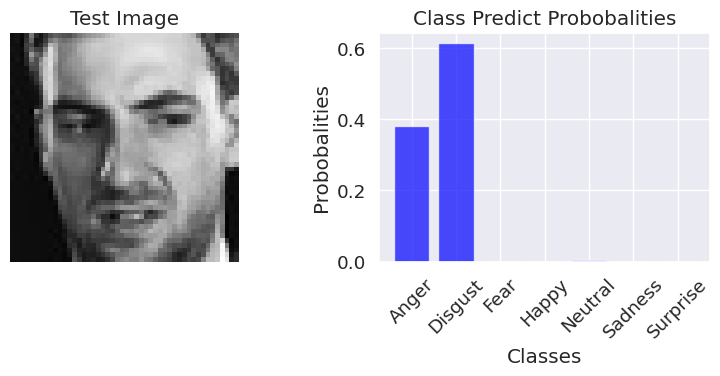

Processing ./Data/fer2013/train/disgust/27201.jpg...
1/1 [==============================] - 0s 20ms/step


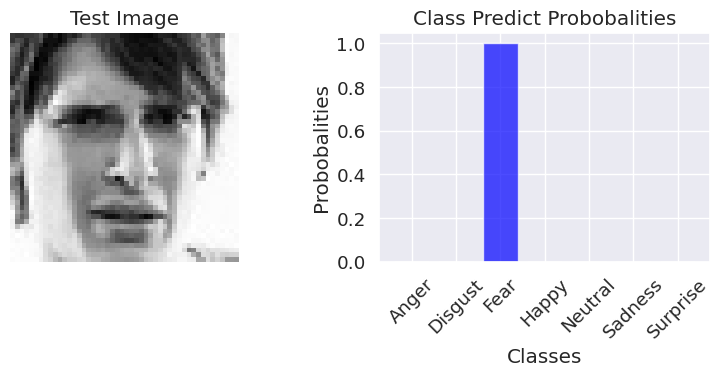

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

def plot_predictions(predictions, class_labels, image):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    x_pos = range(len(class_labels))
    plt.bar(x_pos, predictions, align='center', alpha=0.7, color='blue')
    plt.xticks(x_pos, class_labels, rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Probobalities')
    plt.title('Class Predict Probobalities')

    plt.tight_layout()
    plt.show()

def predict_custom_image(image_path, model):
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (48, 48))
    rgb_img = np.stack((resized_img,)*3, axis=-1)

    predictions = model.predict(rgb_img.reshape(1, 48, 48, 3))
    custom_predict = predictions[0]

    plot_predictions(custom_predict, CLASS_LABELS, resized_img)

    return predictions[0]

image_list = {
    'happy': [
      '27599',
      '1421',
      '18027',
      '1151'
    ],
    'sad': [
        '19504',
        '10321',
        '13600',
        '13614'
    ],
    'fear': [
        '28682',
        '14621',
        '19305',
        '13166'
    ],
    'surprise': [
        '21895',
        '26136',
        '21856',
        '22393'
    ],
    'neutral': [
        '174',
        '11983',
        '19307',
        '19061'
    ],
    'angry': [
        '2672',
        '30783',
        '2100',
        '19463'
    ],
    'disgust': [
        '6548',
        '3626',
        '16591',
        '27201'
    ],
}
base_path = './Data/fer2013/train/'

for emotion, images in image_list.items():
    for image_name in images:
        image_path = f"{base_path}{emotion}/{image_name}.jpg"
        print(f"Processing {image_path}...")

        custom_prediction = predict_custom_image(image_path, loaded_model)

# ResNet50

In [57]:
from keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

def get_model(build,classes):
    model=build.layers[-2].output
    model=GlobalAveragePooling2D()(model)
    model=Dense(classes,activation='softmax',name='output_layer')(model)

    return model

head_resnet = get_model(resnet, 7)

model_resnet = Model(inputs = resnet.input, outputs = head_resnet)

print(model.summary())


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [59]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11,verbose = 1, restore_best_weights = True,)
lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy',factor = 0.5, patience = 7,min_lr = 1e-7,verbose = 1,)
callbacks = [early_stopping,lr_scheduler]
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True)
train_datagen.fit(X_train)


batch_size = 128
epochs = 15

model_resnet.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
              metrics = ['accuracy'])

In [60]:
history = model_resnet.fit(train_datagen.flow(X_train_rgb,
                                       y_train,
                                       batch_size = batch_size),
                                       validation_data = (X_val_rgb, y_val),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/15
221/221 [==============================] - 110s 311ms/step - loss: 2.0839 - accuracy: 0.3200 - val_loss: 776.6166 - val_accuracy: 0.1127 - lr: 1.0000e-04
Epoch 2/15
221/221 [==============================] - 62s 279ms/step - loss: 1.5487 - accuracy: 0.4380 - val_loss: 1.9047 - val_accuracy: 0.1668 - lr: 1.0000e-04
Epoch 3/15
221/221 [==============================] - 55s 244ms/step - loss: 1.4235 - accuracy: 0.4852 - val_loss: 1.8403 - val_accuracy: 0.3066 - lr: 1.0000e-04
Epoch 4/15
221/221 [==============================] - 52s 234ms/step - loss: 1.3109 - accuracy: 0.5219 - val_loss: 1.4965 - val_accuracy: 0.4505 - lr: 1.0000e-04
Epoch 5/15
221/221 [==============================] - 55s 244ms/step - loss: 1.2103 - accuracy: 0.5521 - val_loss: 1.2981 - val_accuracy: 0.5261 - lr: 1.0000e-04
Epoch 6/15
221/221 [==============================] - 51s 231ms/step - loss: 1.1470 - accuracy: 0.5698 - val_loss: 1.3315 - val_accuracy: 0.5272 - lr: 1.0000e-04
Epoch 7/15
221/221 [=====

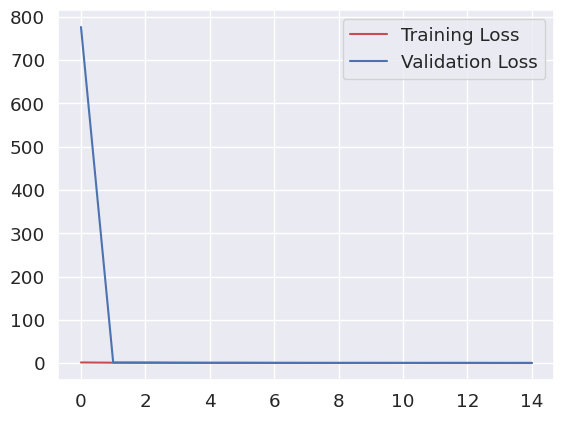

In [61]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

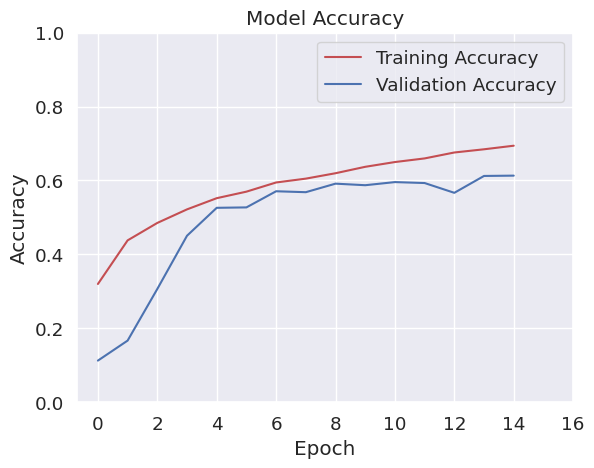

In [62]:
epochs = 15
plt.plot(history.history["accuracy"], 'r', label="Training Accuracy")
plt.plot(history.history["val_accuracy"], 'b', label="Validation Accuracy")

plt.ylim(0.0, 1.0)
plt.xticks(np.arange(0, epochs + 2, 2))

plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

In [63]:
preds = model_resnet.predict(X_test_rgb)
y_pred = np.argmax(preds , axis = 1 )

111/111 [==============================] - 2s 8ms/step


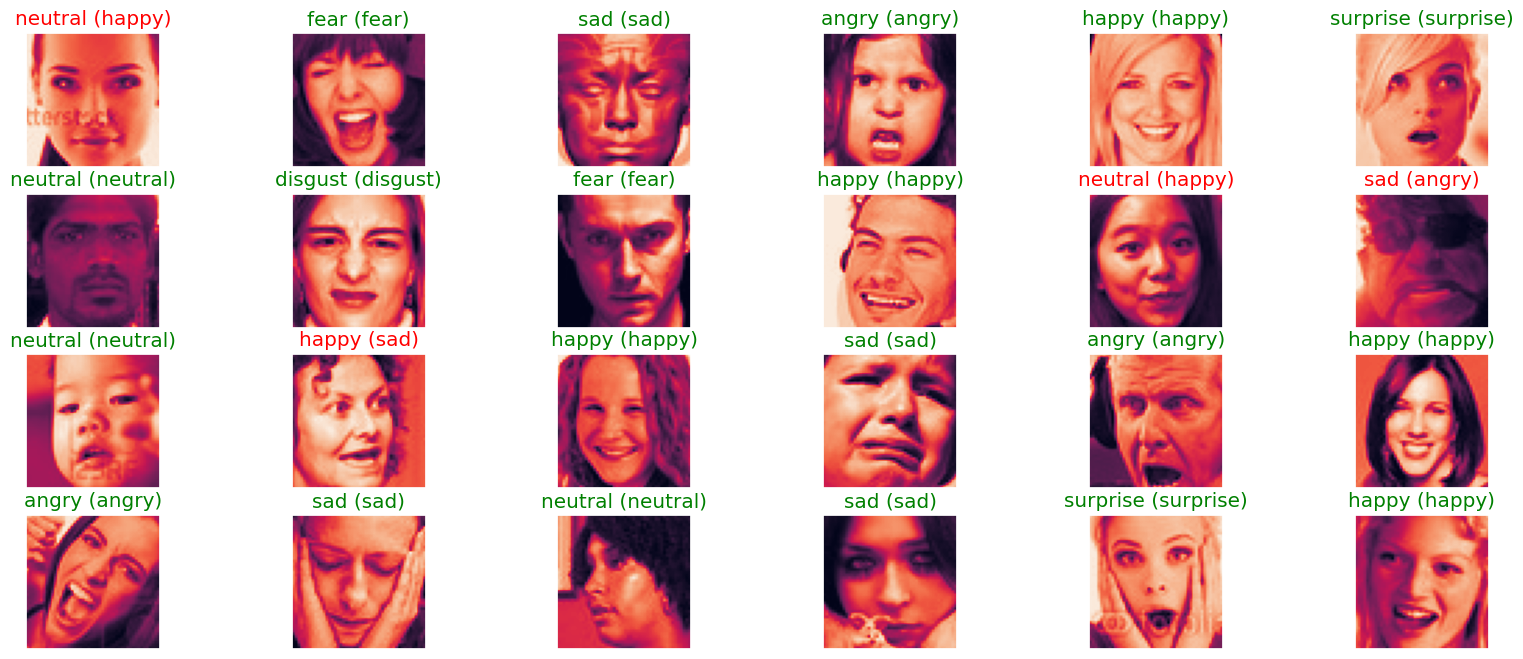

In [64]:
# label_dict = {k: v for k, v in enumerate(lb.classes_)}

# {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

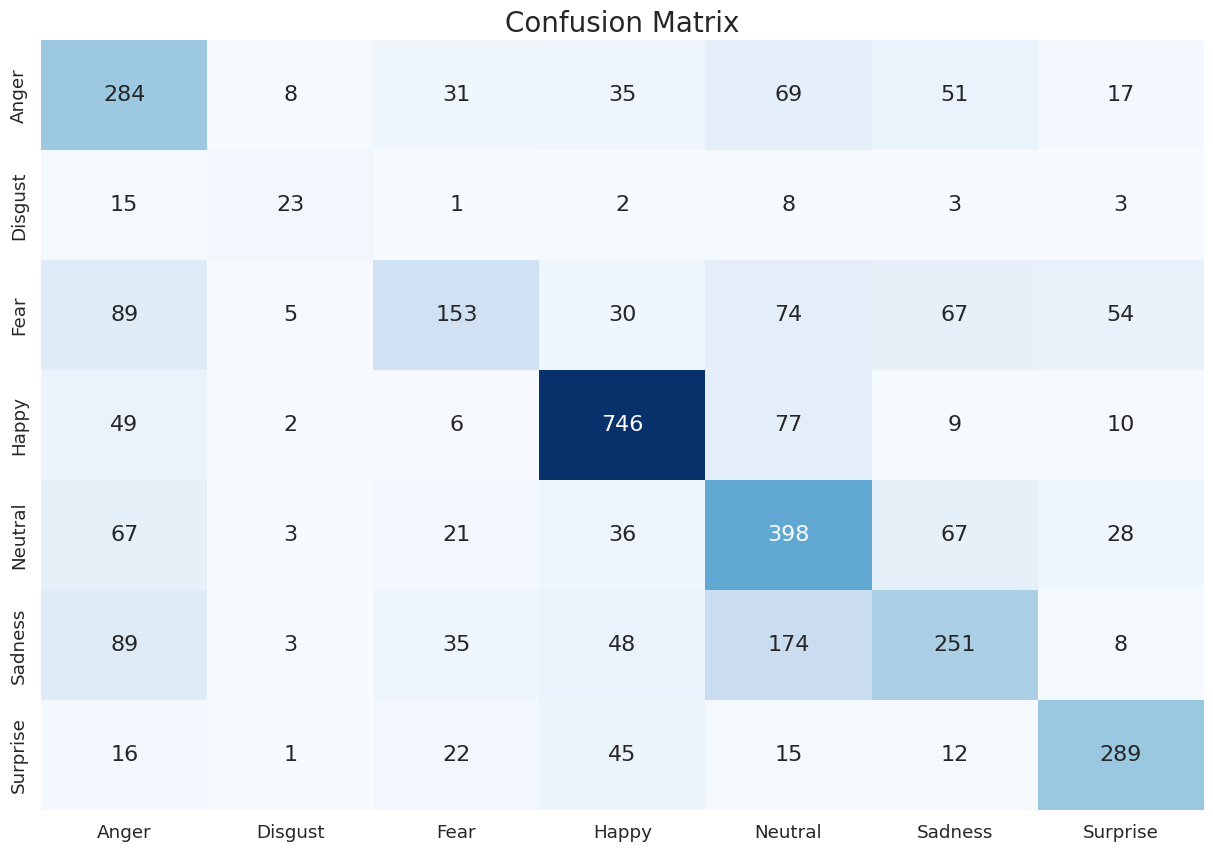

111/111 [==============================] - 1s 10ms/step - loss: 1.1272 - accuracy: 0.6041
Train Acc: 0.7326077222824097 Vall Acc: 0.6131304502487183 Test Acc: 0.6041138172149658


In [65]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(len(CLASS_LABELS)))

cm = pd.DataFrame(cm_data, index=CLASS_LABELS, columns=CLASS_LABELS)

plt.figure(figsize=(15,10))
plt.title('Confusion Matrix', fontsize=20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()
loss_train = model_resnet.evaluate(X_train_rgb,y_train)
loss_val = model_resnet.evaluate(X_val_rgb,y_val)
loss_test = model_resnet.evaluate(X_test_rgb,y_test)
print("Train Acc: " + str(loss_train[1]), "Vall Acc: " + str(loss_val[1]), "Test Acc: " + str(loss_test[1]))
